# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.constants import c, elementary_charge
import pandas as pd
import pickle as pkl
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [12,8] # bigger figures

In [3]:
# import package
# installed via pip
from emtracks.particle import trajectory_solver # main solver object
from emtracks.conversions import one_gev_c2_to_kg # conversion for q factor (transverse momentum estimate)
from emtracks.tools import InitConds # initial conditions namedtuple
from emtracks.mapinterp import get_df_interp_func  # factory function for creating Mu2e DS interpolation function

In [4]:
B_Mu2e_func = get_df_interp_func("Mu2e_DSMap_V13.p", gauss=False)

# Functions

In [5]:
def get_random_phi(N):   #change left boundary to math.pi work with those values later - if it works in some cases, stick with the stuff that works then go back
    # calls np.random, returns np.array with N randomized phi values
    phis = np.random.uniform(0, 2*math.pi, N) # uniform distribution between 0 and 2pi
    return phis

In [6]:
def run_solver(phi, N_calc, field, xnaught, ynaught, znaught):
    ic_Mu2e = InitConds(t0=0., tf=4e-8, N_t=N_calc,
                    x0=xnaught, y0=ynaught, z0=znaught,
                    p0=104.96, theta0=np.pi/3, phi0=phi)
    e_solver = trajectory_solver(ic_Mu2e, B_func=field)
    sol = e_solver.solve_trajectory(verbose = False, atol=1e-6, rtol=1e-6) # high tolerance so it runs quickly for testing
    df = e_solver.dataframe
    df['r'] = ((df['x']-xnaught)**2 + (df['y']-ynaught)**2)**(1/2)
    return df

In [7]:
def find_track_at_z(df, z): 
    delta = 10/4001   #approximate z range divided by number of points
    mask = (df.z < z + delta) & (df.z > z - delta)
    while (len(df.z[mask]) == 0):
        delta = delta*4
        mask = (df.z < z + delta) & (df.z > z - delta)
    while (len(df.z[mask]) > 2):
        delta = delta / 2
        mask = (df.z < z + delta) & (df.z > z - delta)
        
    df2 = df.loc[mask]
    df2 = df2.apply(pd.to_numeric)
    return (df2.iloc[0]['x'], df2.iloc[0]['y'], df2.iloc[0]['z'], df2.iloc[0]['t'], df2.iloc[0]['r'])

In [8]:
def plot_impact_at_calorimeter(ts, phis, rs, xs, ys, zs, output_directory):
    
    fig = plt.figure()
    plt.scatter(xs, ys, c = phis)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Y as a fn of X")
    plt.xlim(-0.5, 0.5)
    plt.ylim(-0.5, 0.5)
    fig.savefig("Scatter y, x")
    
    fig2 = plt.figure()
    plt.scatter(phis, xs)
    plt.xlabel("phi_values (rad)")
    plt.ylabel("x coordinate")
    plt.title("X as a fn of phi")
    plt.xlim(-6, 6)
    plt.ylim(-2, 2)
    fig2.savefig("X as a fn of phi")
    
    fig3 = plt.figure()
    plt.scatter(phis, ys)
    plt.xlabel("phi_values (rad)")
    plt.ylabel("y coordinate")
    plt.title("Y as a fn of phi")
    plt.xlim(-6, 6)
    plt.ylim(-2, 2)
    fig3.savefig("y as a fn of phi")

    fig4 = plt.figure()
    x = xs
    num_bins = 50
    n, bins, patches = plt.hist(x, num_bins, facecolor='blue')
    plt.xlabel('xcoord')
    plt.ylabel('number of occurences')
    plt.title('Histogram of x-coord')
    fig4.savefig("Histogram_of_x-coord")

    fig5 = plt.figure()
    y = ys
    num_bins = 50
    n, bins, patches = plt.hist(y, num_bins, facecolor='blue')
    plt.xlabel('ycoord')
    plt.ylabel('number of occurences')
    plt.title('Histogram of y-coord')
    fig5.savefig("Histogram of y-coord")
    
    fig6 = plt.figure()
    r = rs
    num_bins = 50
    n, bins, patches = plt.hist(r, num_bins, facecolor='blue')
    plt.xlabel('radius')
    plt.ylabel('number of occurences')
    plt.title('Histogram of R')
    fig6.savefig("Histogram_of_R") 
    
    actualrad = ((((max(xs) - min(xs)) / 2) + ((max(ys) - min(ys)) / 2)) / 2)
    print ('actual radius: ' + str(actualrad))

### You can define whatever graded function you want this way (but would have to alter run_solver)

In [9]:
# def gradedBfunc(x, y, z, slope, z0, bz0):  #Bz = b(z-z0)+bz0
    
#     r = sqrt(x**2 + y**2)
#     phi = math.atan(y/x) #radians
#     br = -r * (slope/2)
    
#     Bxgraded = br * math.cos(phi)
#     Bygraded = br * math.sin(phi)
#     Bzgraded = slope*(z-z0) + bz0
    
#     bx = B_Mu2e_func([x,y,z])[0]
#     by = B_Mu2e_func([x,y,z])[1]
#     bz = B_Mu2e_func([x,y,z])[2]

#     return (bx+Bxgraded, by+Bygraded, bz+Bzgraded)

### Function for graded B-field

In [10]:
def gradedBfunc(s):  #Bz = b(z-z0)+bz0
    x = s[0]
    y = s[1]
    z = s[2]
    
    r = math.sqrt(x**2 + y**2)  # dont be wasteful with sqrt, #numpy.sqrt is better
    
    if (y > 0 and x <0) or (y < 0 and x < 0):
        phi = math.atan(y/x) + math.pi/2 #radians
    else:
        phi = math.atan(y/x)
    
    br = -r * (-1/2)
    
    Bxgraded = br * math.cos(phi)    #br * x/r -- get rid of arctan, good habit to avoid trig / other trans fn
    Bygraded = br * math.sin(phi)
    
    bx = B_Mu2e_func([x,y,z])[0]
    by = B_Mu2e_func([x,y,z])[1]
    bz = B_Mu2e_func([x,y,z])[2]

    return ([bx+Bxgraded, by+Bygraded, bz+Bzgraded])

## First Run Function (No Graded Field)

In [11]:
def run(N, output_directory):
    phis = get_random_phi(N)
    ts = []
    xs = []
    ys = []
    zs = []
    rs = []
    # for each phi, run create solver object and save trajectory object
    for phi in phis:
        dataframe = run_solver(phi, 4001, B_Mu2e_func, 0.054094482, 0.03873037, 5.988900879) #second argument is how many steps in numerical integration
        x, y, z, t, r = find_track_at_z(dataframe,13)
        ts.append(t)
        xs.append(x)
        ys.append(y)
        zs.append(z)
        rs.append(r)
    # convert everything to numpy arrays
    ts = np.array(ts)
    xs = np.array(xs)
    ys = np.array(ys)
    zs = np.array(zs)
    rs = np.array(rs)
    # plot results (and save plots)
    plot_impact_at_calorimeter(ts, phis, rs, xs, ys, zs, output_directory)
    return (ts, phis, rs, xs, ys, zs)

actual radius: 0.37391661538891213


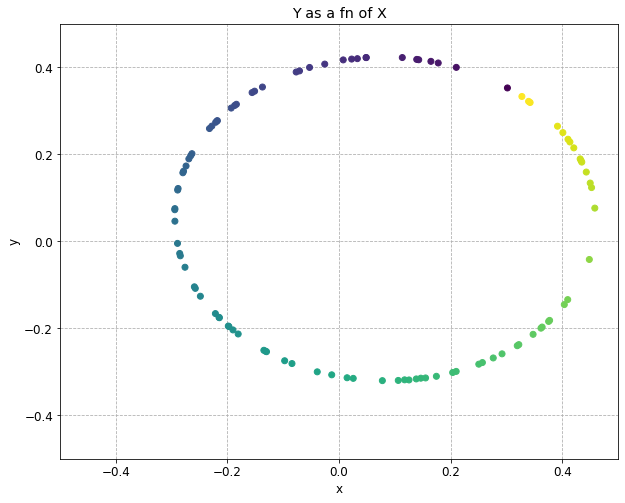

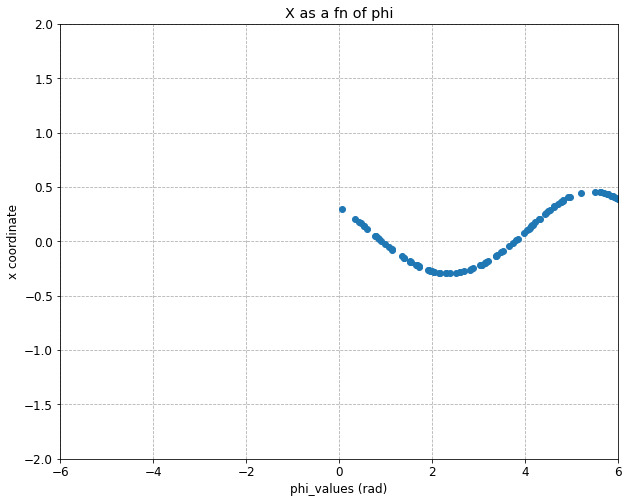

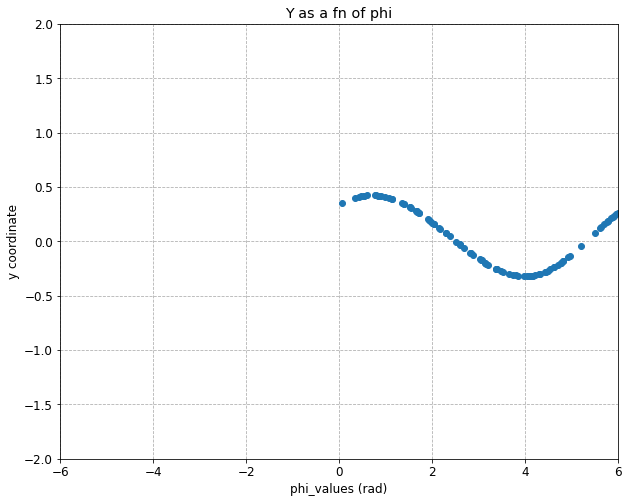

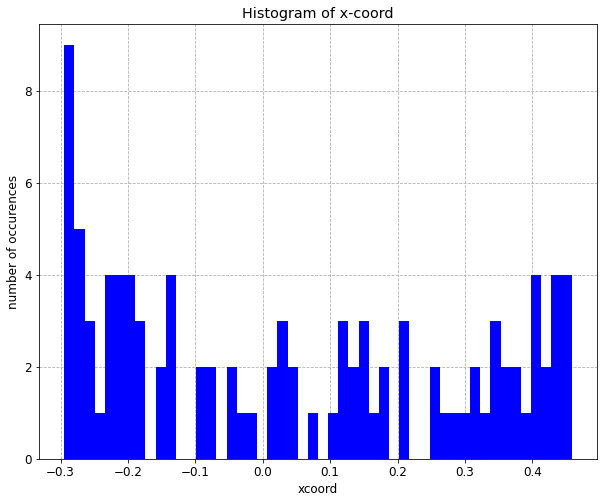

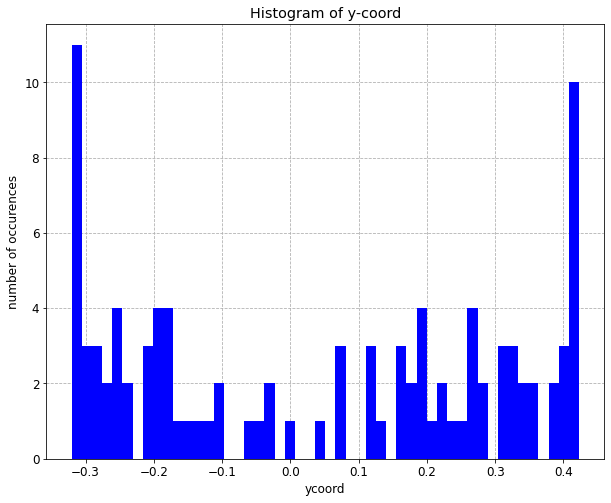

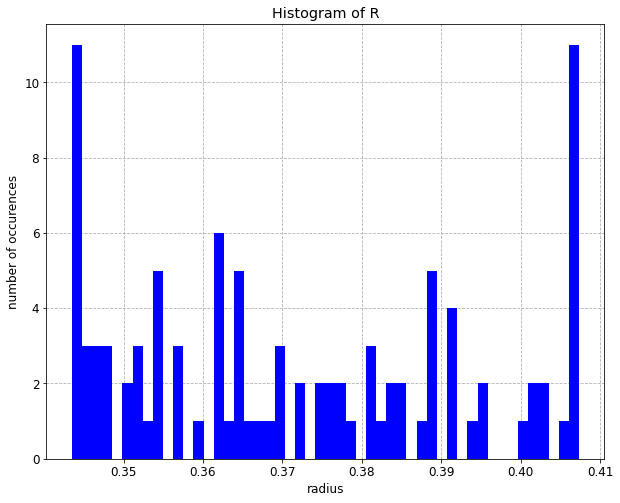

In [12]:
x = run(100, "plots2")
#np.save(x)

## Second Run Function (Graded Field)

In [13]:
def run2(N, output_directory):
    phis = get_random_phi(N)
    ts = []
    xs = []
    ys = []
    zs = []
    rs = []
    # for each phi, run create solver object and save trajectory object
    for phi in phis:
        dataframe = run_solver(phi, 4001, gradedBfunc, 0.054094482, 0.03873037, 5.988900879) #second argument is how many steps in numerical integration
        x, y, z, t, r = find_track_at_z(dataframe,13)
        ts.append(t)
        xs.append(x)
        ys.append(y)
        zs.append(z)
        rs.append(r)
    # convert everything to numpy arrays
    ts = np.array(ts)
    xs = np.array(xs)
    ys = np.array(ys)
    zs = np.array(zs)
    rs = np.array(rs)
    # plot results (and save plots)
    plot_impact_at_calorimeter(ts, phis, rs, xs, ys, zs, output_directory)
    return (ts, phis, rs, xs, ys, zs)
    

actual radius: 0.1963375304737886


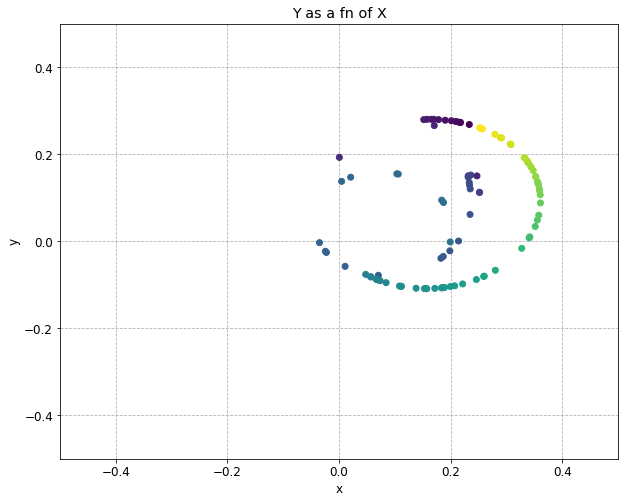

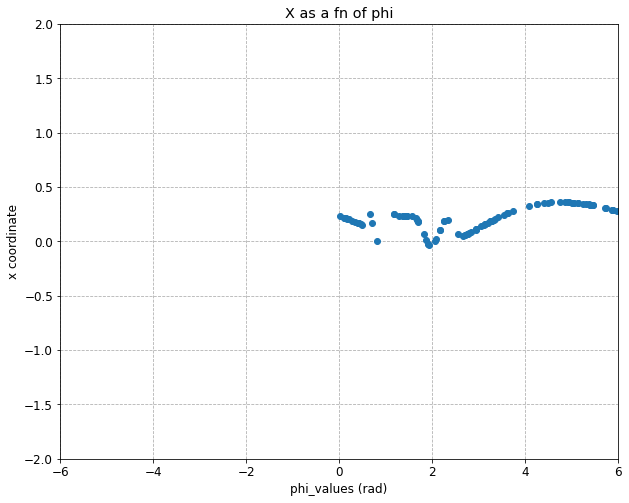

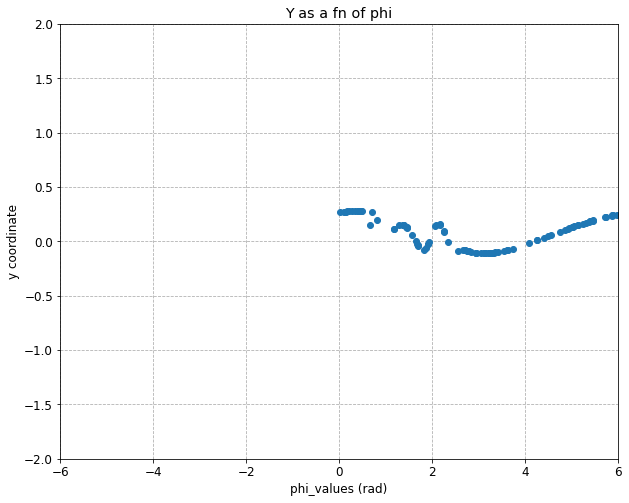

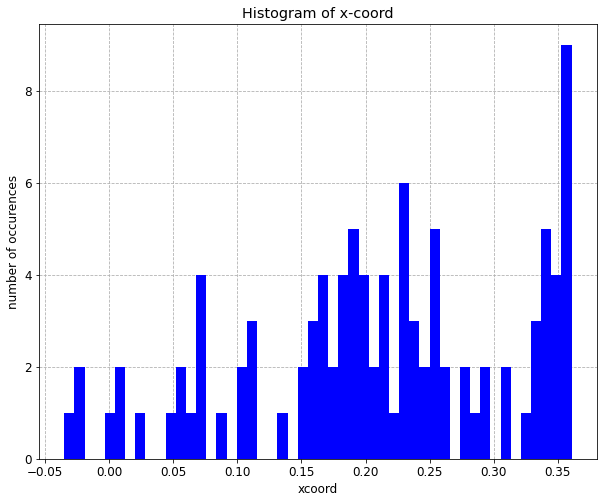

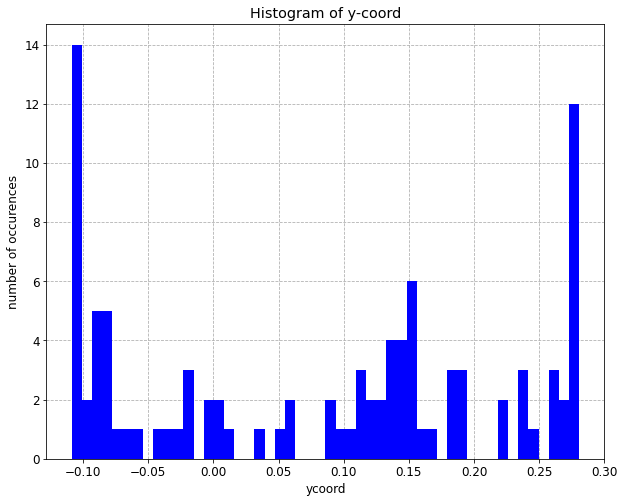

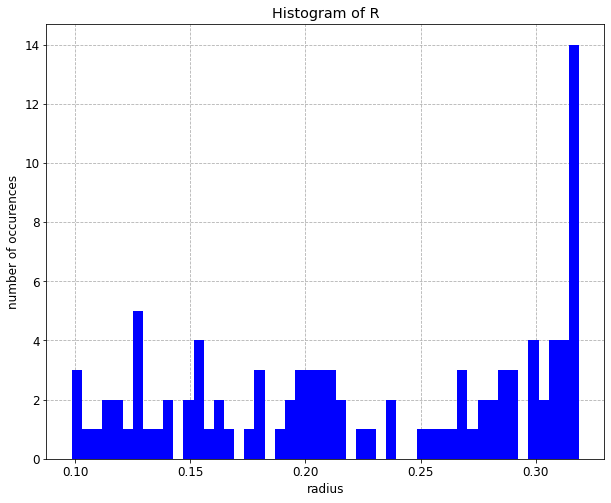

In [14]:
y = run2(100, 'plots3')

<bound method Figure.show of <Figure size 720x576 with 1 Axes>>

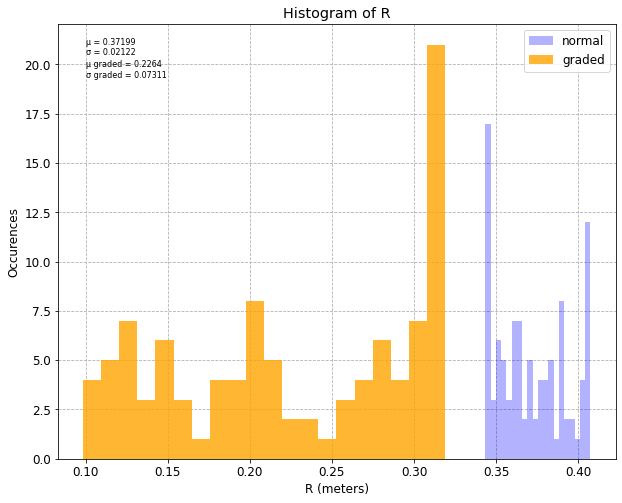

In [23]:
#x is regular, y is graded
x1, x2 = x[2], y[2]
num_bins = 20

m1 = np.mean(x1)
std1 = np.std(x1)
m2 = np.mean(x2)
std2 = np.std(x2)

fig = plt.figure()

plt.hist(x1, alpha = 0.3, bins = num_bins, facecolor='blue', label = 'normal')
plt.hist(x2, alpha = 0.8, bins = num_bins, facecolor='orange', label = 'graded')

plt.legend()
plt.legend()

plt.text(0.1, 21, '\u03BC = '+str(round(np.mean(x1), 5)), fontsize = 8)
plt.text(0.1, 20.5, '\u03C3 = '+str(round(np.std(x1), 5)), fontsize = 8)
plt.text(0.1, 19.9, '\u03BC graded = '+str(round(np.mean(x2), 5)), fontsize = 8)
plt.text(0.1, 19.3, '\u03C3 graded = '+str(round(np.std(x2), 5)), fontsize = 8)

plt.xlabel('R (meters)')
plt.ylabel('Occurences')
plt.title('Histogram of R')  
fig.show

<bound method Figure.show of <Figure size 720x576 with 1 Axes>>

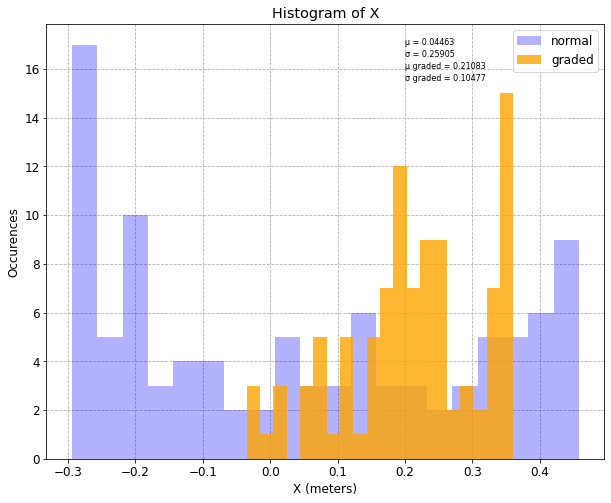

In [25]:
#x is regular, y is graded
x1, x2 = x[3], y[3]
num_bins = 20
m1 = np.mean(x1)
std1 = np.std(x1)
m2 = np.mean(x2)
std2 = np.std(x2)

fig = plt.figure()

plt.hist(x1, alpha = 0.3, bins = num_bins, facecolor='blue',  label = 'normal')
plt.hist(x2, alpha = 0.8, bins = num_bins, facecolor='orange',  label = 'graded')

plt.legend()


plt.text(0.2, 17, '\u03BC = '+str(round(np.mean(x1), 5)), fontsize = 8)
plt.text(0.2, 16.5, '\u03C3 = '+str(round(np.std(x1), 5)), fontsize = 8)
plt.text(0.2, 16, '\u03BC graded = '+str(round(np.mean(x2), 5)), fontsize = 8)
plt.text(0.2, 15.5, '\u03C3 graded = '+str(round(np.std(x2), 5)), fontsize = 8)

plt.xlabel('X (meters)')
plt.ylabel('Occurences')
plt.title('Histogram of X')  
fig.show

<bound method Figure.show of <Figure size 720x576 with 1 Axes>>

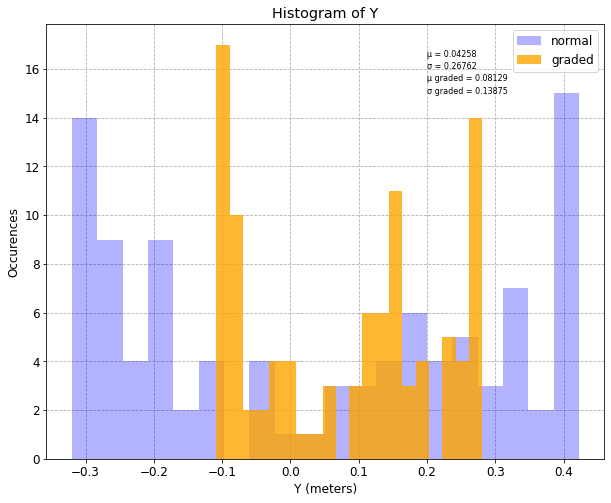

In [26]:
#x is regular, y is graded
x1, x2 = x[4], y[4]
num_bins = 20
m1 = np.mean(x1)
std1 = np.std(x1)
m2 = np.mean(x2)
std2 = np.std(x2)

fig = plt.figure()

plt.hist(x1, alpha = 0.3, bins = num_bins, facecolor='blue',  label = 'normal')
plt.hist(x2, alpha = 0.8, bins = num_bins, facecolor='orange',  label = 'graded')

plt.legend()

plt.text(0.2, 16.5, '\u03BC = '+str(round(np.mean(x1), 5)), fontsize = 8)
plt.text(0.2, 16, '\u03C3 = '+str(round(np.std(x1), 5)), fontsize = 8)
plt.text(0.2, 15.5, '\u03BC graded = '+str(round(np.mean(x2), 5)), fontsize = 8)
plt.text(0.2, 15, '\u03C3 graded = '+str(round(np.std(x2), 5)), fontsize = 8)

plt.xlabel('Y (meters)')
plt.ylabel('Occurences')
plt.title('Histogram of Y')  
fig.show

# Unused Code

In [ ]:
def rungraded(N, filename, output_directory, bxgrating, bygrating, bzgrating):
    
    df2 = pd.read_pickle(filename)
    df2['Grated Bx'] = df2['Bx'] + bxgrating
    df2['Grated By'] = df2['By'] + bygrating
    df2['Grated Bz'] = df2['Bz'] + bzgrating
    df2['Bx'] = df2['Grated Bx']
    df2['By'] = df2['Grated By']
    df2['Bz'] = df2['Grated Bz']
    del df2['Grated Bx']
    del df2['Grated By']
    del df2['Grated Bz']
    
    B_gratedfunc = get_df_interp_func(df = df2, gauss=False)
    phis = get_random_phi(N)
    
    ts = []
    xs = []
    ys = []
    zs = []
    rs = []
    # for each phi, run create solver object and save trajectory object
    print(type(B_gratedfunc))
    for phi in phis:
        dataframe = run_solver(phi, 4001, B_gratedfunc, 0.054094482, 0.03873037, 5.988900879) #second argument is how many steps in numerical integration
        x, y, z, t, r = find_track_at_z(dataframe,13)
        ts.append(t)
        xs.append(x)
        ys.append(y)
        zs.append(z)
        rs.append(r)
        print("5")
    # convert everything to numpy arrays
    ts = np.array(ts)
    xs = np.array(xs)
    ys = np.array(ys)
    zs = np.array(zs)
    # plot results (and save plots)
    plot_impact_at_calorimeter(ts, phis, rs, xs, ys, zs, output_directory)
    
    
    df9 = pd.read_pickle("Mu2e_DSMap_V13.p")
df3 = df9.head(1000)
#df3 mu2e field
#df4 empty dataframe

df4 = pd.DataFrame(index=range(0,len(df3)),columns=['X','Y','Z','Bx','By','Bz','R','Phi','Bphi','Br'])
df4.at[2,'X'] = 2

for index, row in df3.iterrows():
    x = row['X']
    y = row['Y']
    z = row['Z']
    bx = row['Bx']
    by = row['By']
    bz = row['Bz']
    r = row['R']
    phi = row['Phi']
    bphi = row['Bphi']
    br = row['Br']
    
    df4.at[index,'X'] = x
    df4.at[index,'Y'] = y
    df4.at[index,'Z'] = z
    df4.at[index,'Bx'] = 
    df4.at[index,'By'] = 
    df4.at[index,'Bz'] = 
    df4.at[index,'R'] = r
    df4.at[index,'Phi'] = phi
    df4.at[index,'Bphi'] = 
    df4.at[index,'Br'] = 

    
    
B_gratedfunc2 = get_df_interp_func(df = df4, gauss=False)
repeat all above --

#figure out this
#figure out how to put two plots in one histogram, how it would look
#different color for each set + legend, alpha (opacity) = how see-through each histogram is
#alpha between 0-1 (0 completely transparent) (so nothing is blocked)
#add statistics to the legend
#package named brute
#understand interpolation function
    
x1, x2 = x[1], y[1]
num_bins = 50

fig = plt.figure()

n, bins, patches = plt.hist(x1, bins = num_bins, facecolor='blue')
n, bins, patches = plt.hist(x2, bins = num_bins, facecolor='red')
plt.xlabel('x')
plt.ylabel('number of occurences')
plt.title('Histogram of X')  
fig.show

In [ ]:
B_Mu2e_func([1, 2, 3])